In [39]:
import numpy as np
import configparser
import pandas as pd
import tdr_utils as ut

In [40]:
# Get parameters from configuration file
config = configparser.ConfigParser()
config.read('tdr-parameters.ini')

threshold = int(config['signal']['threshold'])
frequency = float(config['signal']['frequency'])
duty_cycle = float(config['signal']['duty_cycle'])
num_samples = int(config['signal']['num_samples'])
sampling_rate = float(config['signal']['sampling_rate'])

num_edges = int(config['search']['num_edges']) #number of rising and falling, each, edges to search for
overlap_offset = int(config['search']['overlap_offset']) #number of samples to offset overlap threshold with

win_size = int(config['win_interest']['win_size']) 
prior_samples = int(config['win_interest']['prior_samples']) # samples to consider before rising/falling edge index

_num_edges = 1
overlap_threshold = duty_cycle * (sampling_rate / frequency) - overlap_offset
t = np.linspace(0, num_samples / sampling_rate, num=num_samples) * 1000 #time in milliseconds

### 12.41 m
Short circuit at 12.41 m from the input port

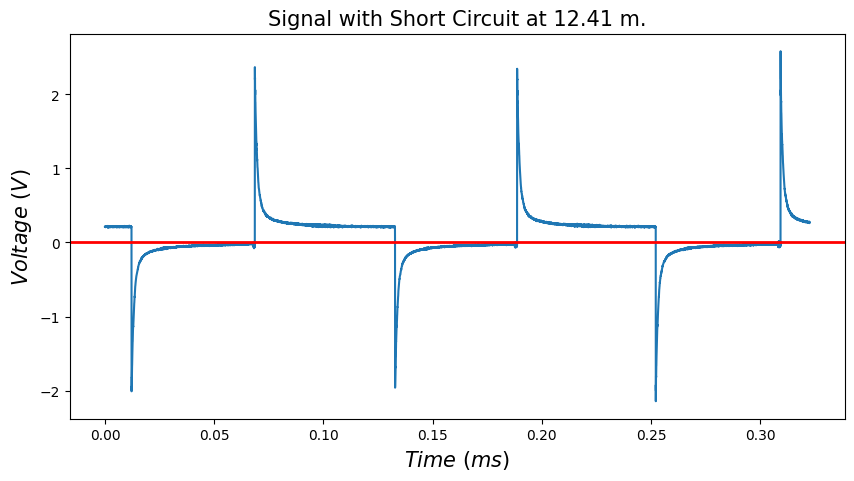

In [41]:
short_12m_files_dir = './data/short-circuit/12m'

#load a random file
v_short_12m = ut.random_file_load(short_12m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_12m, 'Signal with Short Circuit at 12.41 m.')

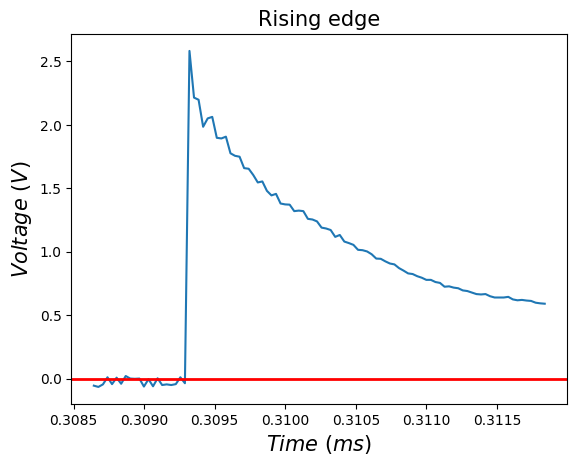

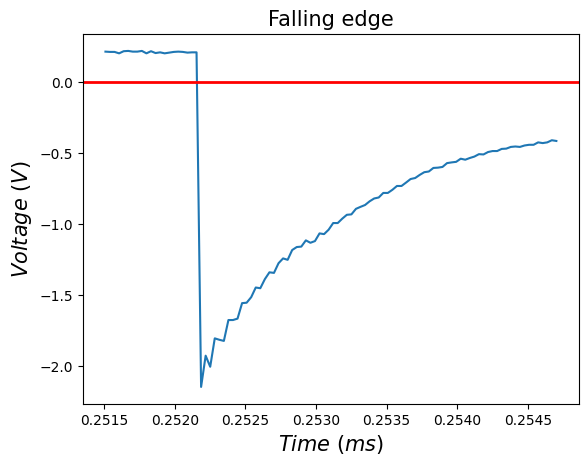

In [42]:
#locate rising a rising edge and a falling edge in the signal
short_12m_edges_indices = ut.edges_detection(v_short_12m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_12m, t, short_12m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

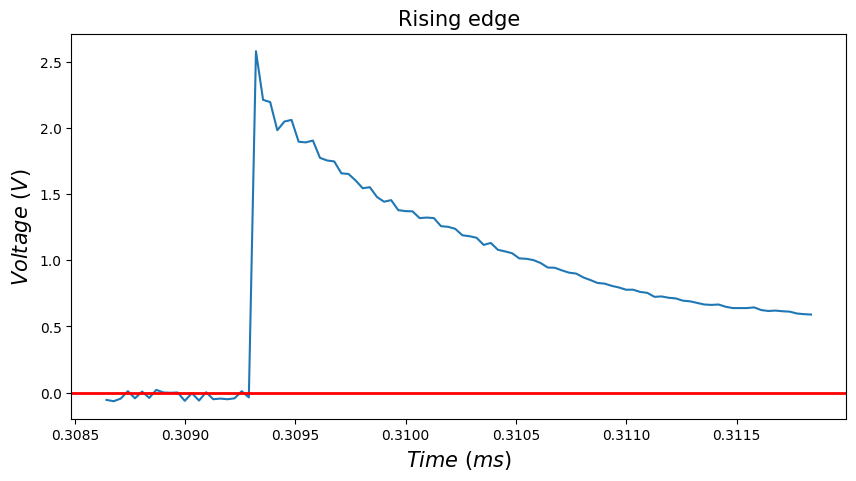

In [43]:
rising_edge_indx = short_12m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_12m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

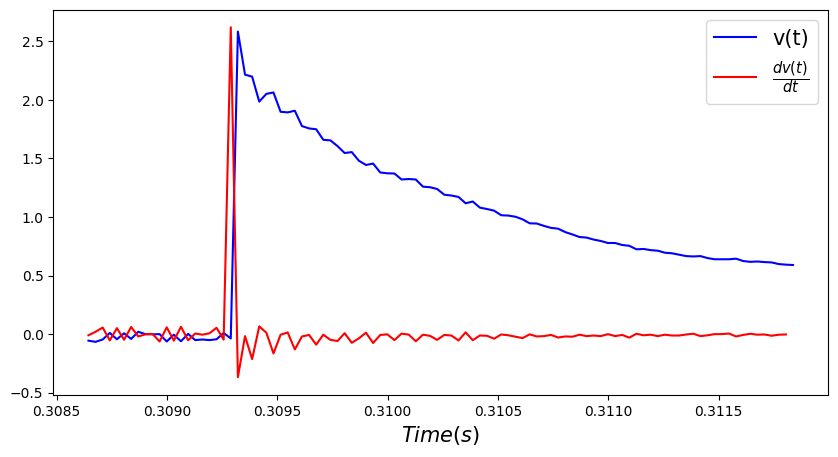

In [44]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

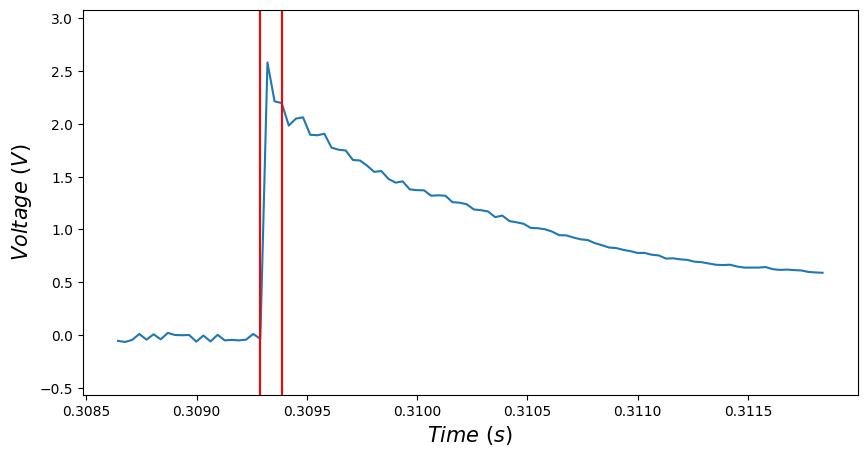

Timed delay is 9.678387193556848e-05 ms


In [45]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [46]:
p_rising_fault = ut.fault_point(t_rising_delay)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 13.944136349117029 m


In [47]:
#model performance
performance = ut.performance_metrics(12.41, p_rising_fault, metrics=['mse'])
print('Model performance metrics outcome for a single rising edge:', performance)

Model performance metrics outcome for a single rising edge: Metrics(mse=2.353574337682126, rmse=1.5341363491170288)


#### 2. Falling edge

Change point detection on a falling edge

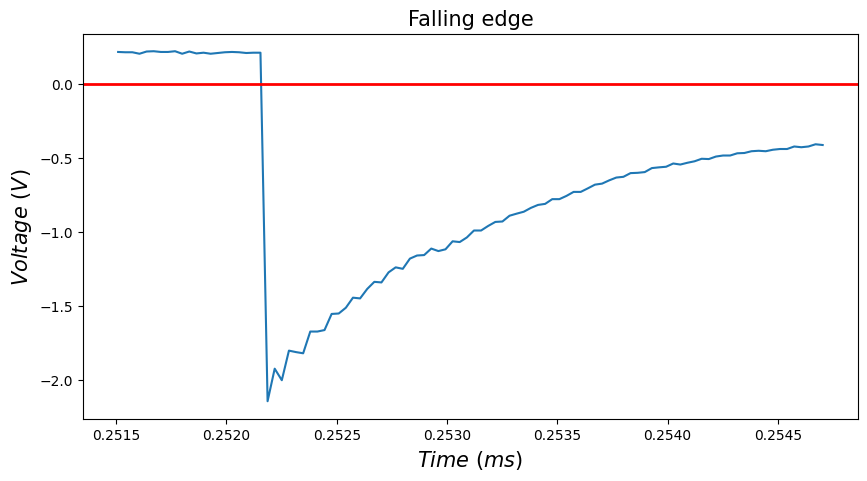

In [48]:
falling_edge_indx = short_12m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_12m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

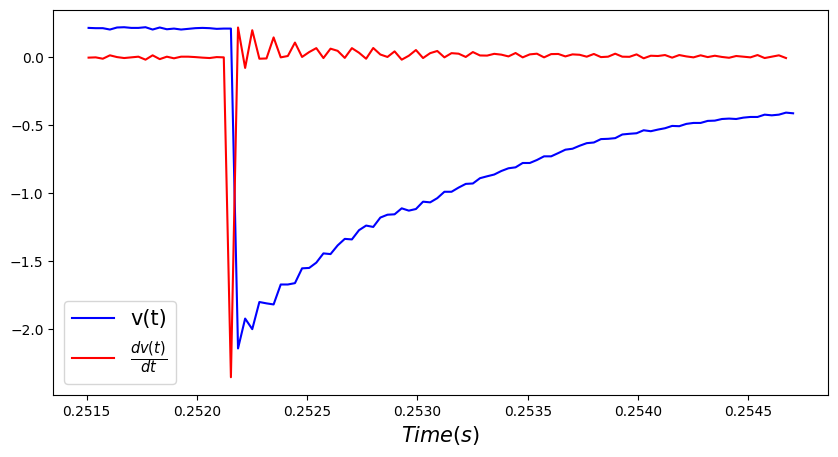

In [49]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

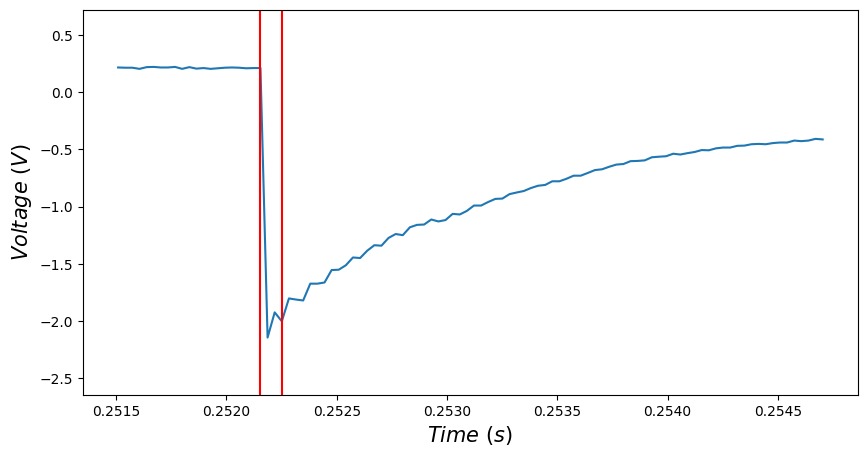

Timed delay is 9.678387193562399e-05 ms


In [50]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [51]:
p_falling_fault = ut.fault_point(t_falling_delay)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 13.944136349125028 m


In [52]:
#model performance
performance = ut.performance_metrics(12.41, p_falling_fault, metrics=['mse'])
print('Model performance metrics outcome for a single falling edge:', performance)

Model performance metrics outcome for a single falling edge: Metrics(mse=2.353574337706669, rmse=1.5341363491250277)


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [53]:
#locate rising rising edges and a falling edges in the signal
short_12m_edges_indices = ut.edges_detection(v_short_12m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_12m_edges_indices)

{'rising_edges': [5848, 2126, 9587], 'falling_edges': [7816, 376, 4116]}


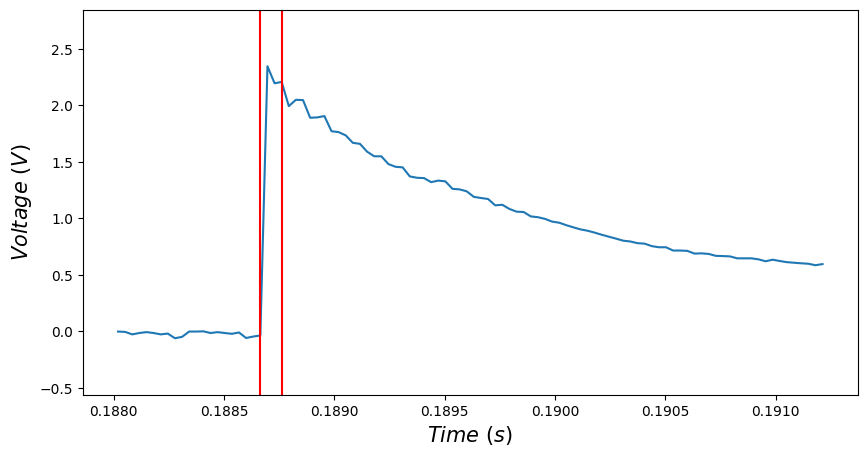

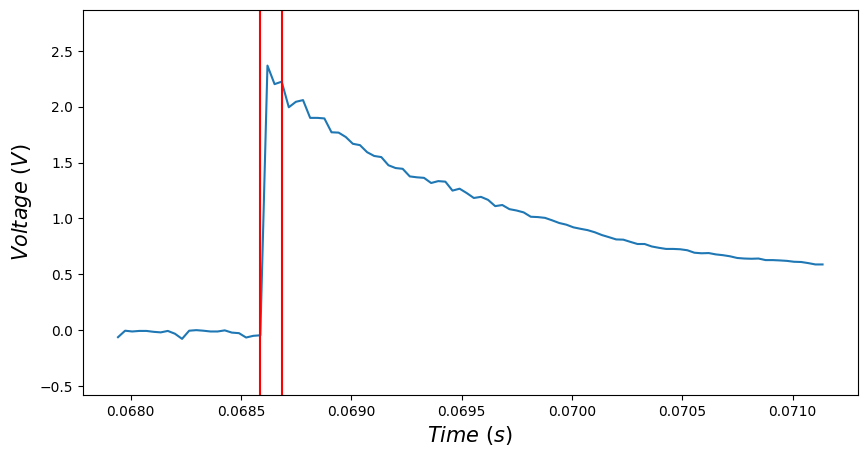

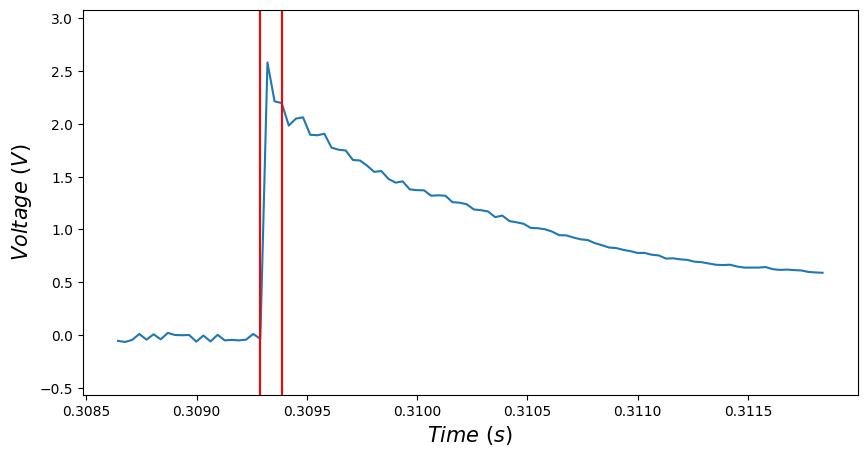

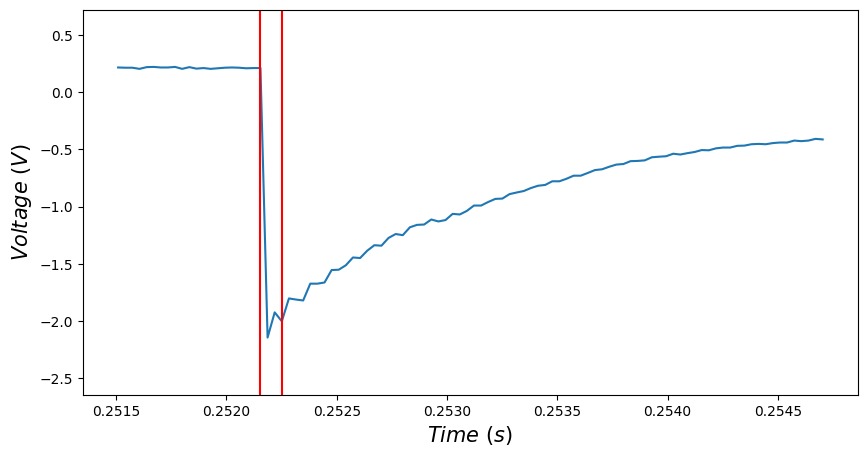

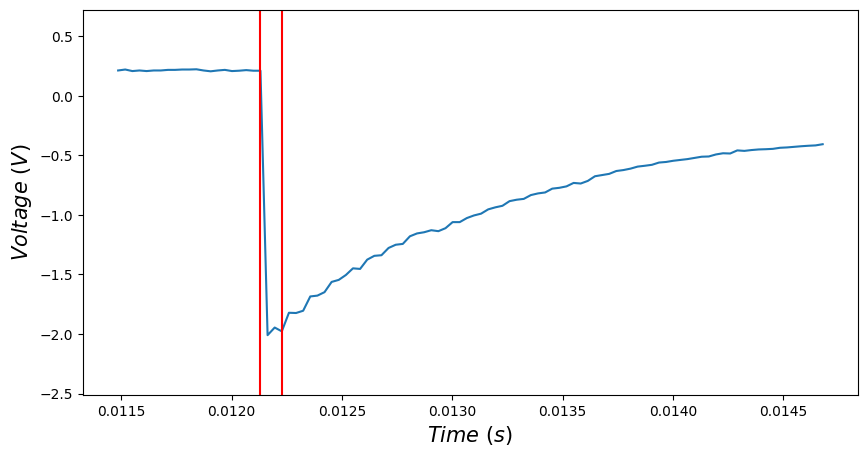

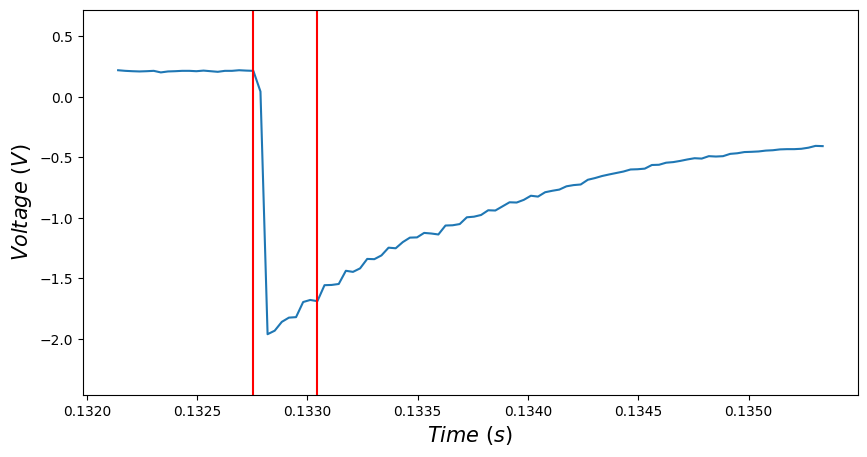

[9.67838719e-05 9.67838719e-05 9.67838719e-05 9.67838719e-05
 9.67838719e-05]
Average time delay is 9.678387193559068e-05 ms


In [54]:
avg_t_short_12m_delay,  t_short_12m_delays = ut.avg_delay(short_12m_edges_indices, win_size, v_short_12m, t, prior_samples)

print(t_short_12m_delays)
print('Average time delay is {} ms'.format(avg_t_short_12m_delay))

In [55]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_12m_delay)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 13.944136349120226 m


In [56]:
#model performance
performance = ut.performance_metrics(12.41, p_short_fault, metrics=['mse'])
print('Model performance metrics outcome for the whole signal:', performance)

Model performance metrics outcome for the whole signal: Metrics(mse=2.3535743376919367, rmse=1.5341363491202262)


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [57]:
short_12m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
e_values = []
paths = ut.file_paths(short_12m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_12m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_12m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_12m_edges_indices = ut.edges_detection(v_short_12m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_12m_delay,  t_short_12m_delays = ut.avg_delay(short_12m_edges_indices, win_size, v_short_12m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_12m_delay)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_12m_delay)
        distance_to_fault.append(p_short_fault)
        e_values.append(12.41)
        
short_12m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_12m = pd.DataFrame(short_12m_circuit_files)
        
df_short_12m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/12m/short-106-12-1.csv,0.000097,13.944136
1,./data/short-circuit/12m/short-106-12-10.csv,0.000097,13.944136
2,./data/short-circuit/12m/short-106-12-11.csv,0.000097,13.944136
3,./data/short-circuit/12m/short-106-12-12.csv,0.000097,13.944136
4,./data/short-circuit/12m/short-106-12-13.csv,0.000097,13.944136
5,./data/short-circuit/12m/short-106-12-14.csv,0.000097,13.944136
6,./data/short-circuit/12m/short-106-12-15.csv,0.000097,13.944136
7,./data/short-circuit/12m/short-106-12-16.csv,0.000097,13.944136
8,./data/short-circuit/12m/short-106-12-17.csv,0.000097,13.944136
9,./data/short-circuit/12m/short-106-12-18.csv,0.000097,13.944136


In [58]:
#model performance
performance = ut.performance_metrics(e_values, distance_to_fault)
print('Model performance metrics outcome for all data:', performance)

Model performance metrics outcome for all data: Metrics(mse=2.353574337688916, rmse=1.5341363491192417, mae=1.5341363491192415, irm=1.0)


### 17.44 m
Short circuit at 17.44 m from the input port

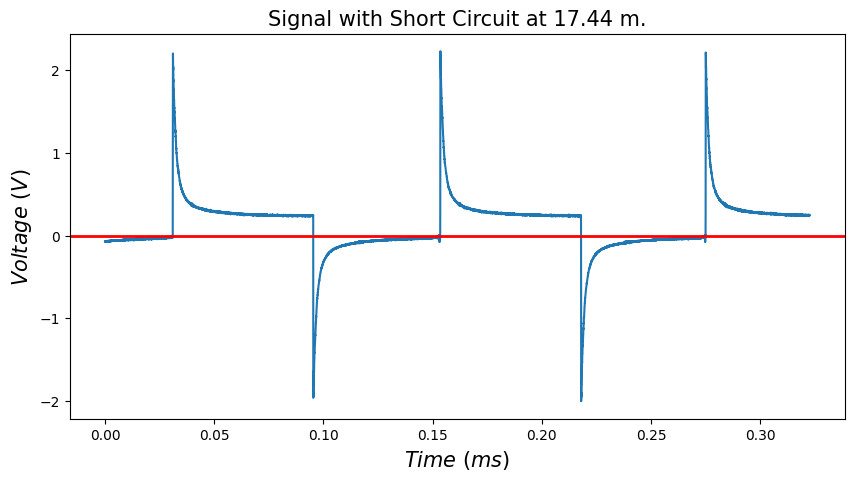

In [59]:
short_17m_files_dir = './data/short-circuit/17m'

#load a random file
v_short_17m = ut.random_file_load(short_17m_files_dir, num_samples, threshold)

#plot the loaded signal
ut.single_plot(t, v_short_17m, 'Signal with Short Circuit at 17.44 m.')

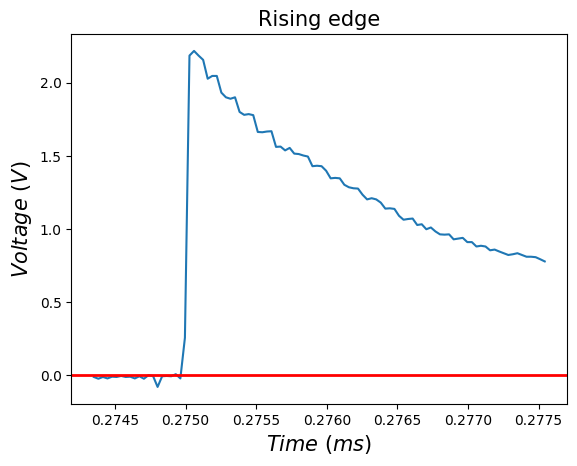

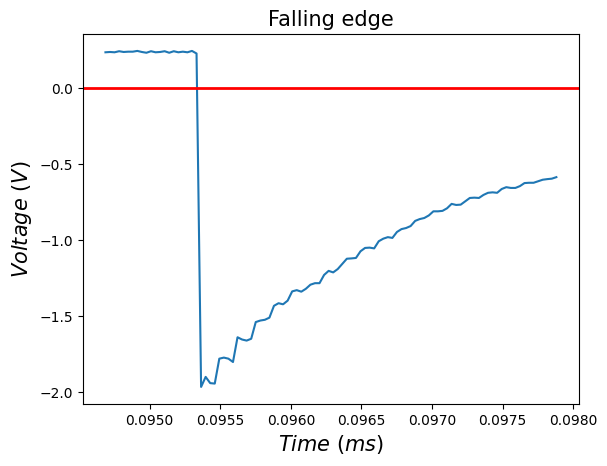

In [60]:
#locate rising a rising edge and a falling edge in the signal
short_17m_edges_indices = ut.edges_detection(v_short_17m, t, _num_edges, win_size, prior_samples, overlap_threshold)

#plot rising and falling edges
ut.edges_plots(v_short_17m, t, short_17m_edges_indices, win_size, prior_samples)

#### 1. Rising edge

Change point detection on a rising edge

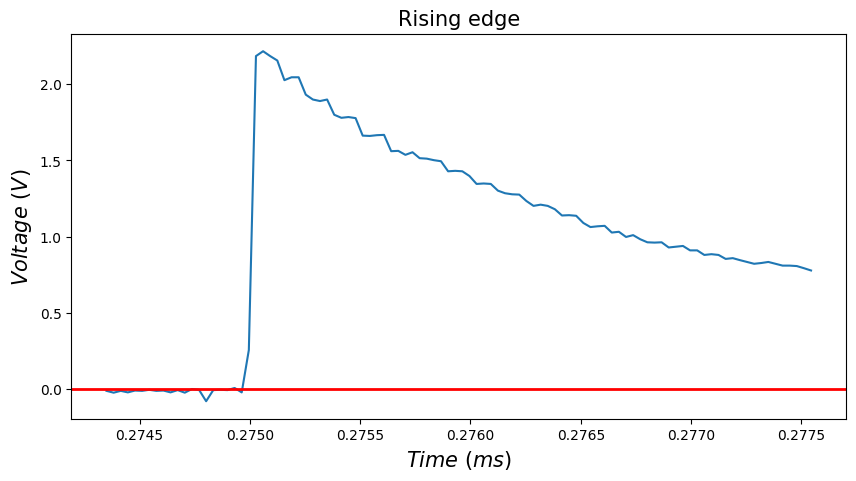

In [61]:
rising_edge_indx = short_17m_edges_indices['rising_edges'][0]
t_rising_seg, v_rising_seg = ut.win_generator(v_short_17m, t, rising_edge_indx, win_size, prior_samples)

plot_title = 'Rising edge'
ut.single_plot(t_rising_seg, v_rising_seg, plot_title)

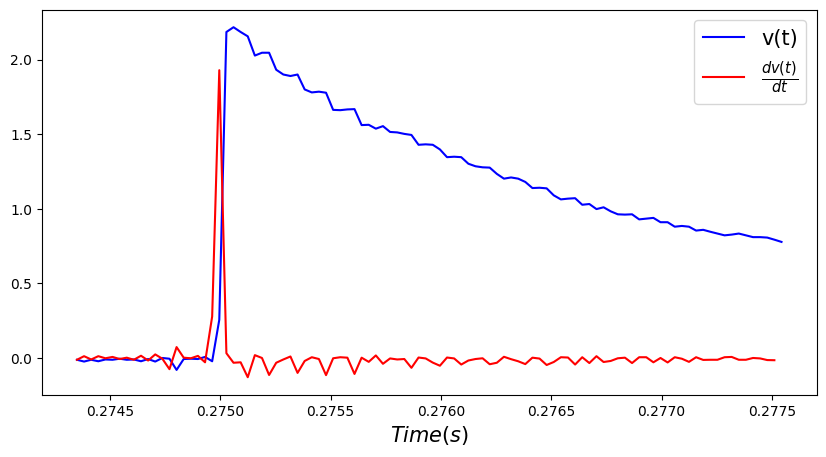

In [62]:
#let's plot the derivative of the signal and the signal
s_rising_derivative = ut.sig_derivative(v_rising_seg, t_rising_seg)

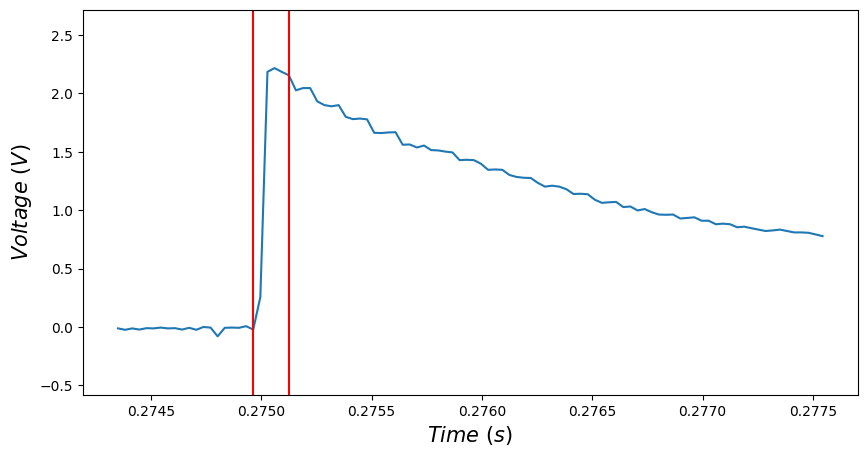

Timed delay is 0.00016130645322598447 ms


In [63]:
t_rising_delay = ut.time_delay(v_rising_seg, t_rising_seg, display=True)
print('Timed delay is {} ms'.format(t_rising_delay))

In [64]:
p_rising_fault = ut.fault_point(t_rising_delay)

print('Distance to the fault is {} m'.format(p_rising_fault))

Distance to the fault is 23.240227248533714 m


In [65]:
#model performance
performance = ut.performance_metrics(17.44, p_rising_fault, metrics=['mse'])
print('Model performance metrics outcome for a single rising edge:', performance)

Model performance metrics outcome for a single rising edge: Metrics(mse=33.64263613463296, rmse=5.800227248533712)


#### 2. Falling edge

Change point detection on a falling edge

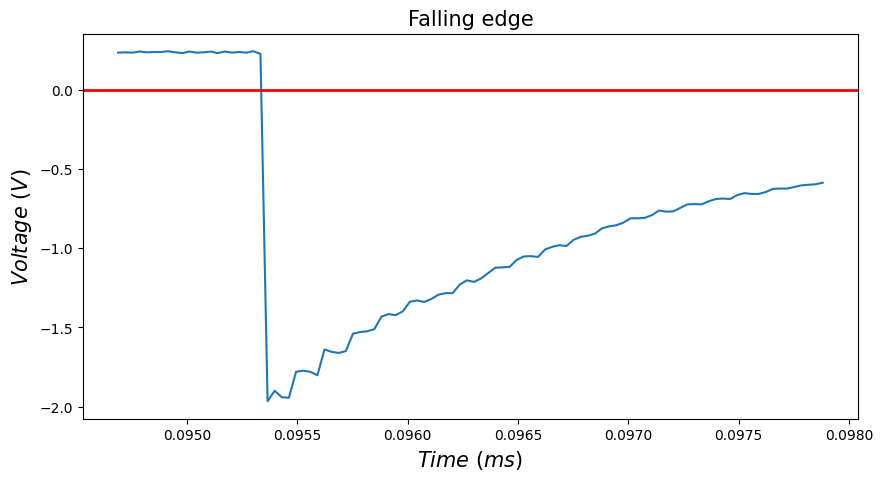

In [66]:
falling_edge_indx = short_17m_edges_indices['falling_edges'][0]
t_falling_seg, v_falling_seg = ut.win_generator(v_short_17m, t, falling_edge_indx, win_size, prior_samples)

plot_title = 'Falling edge'
ut.single_plot(t_falling_seg, v_falling_seg, plot_title)

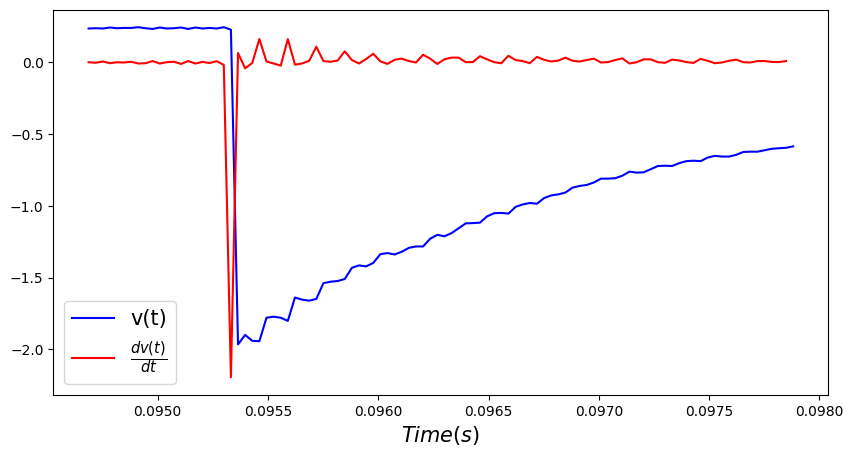

In [67]:
#let's plot
s_falling_derivative = ut.sig_derivative(v_falling_seg, t_falling_seg)

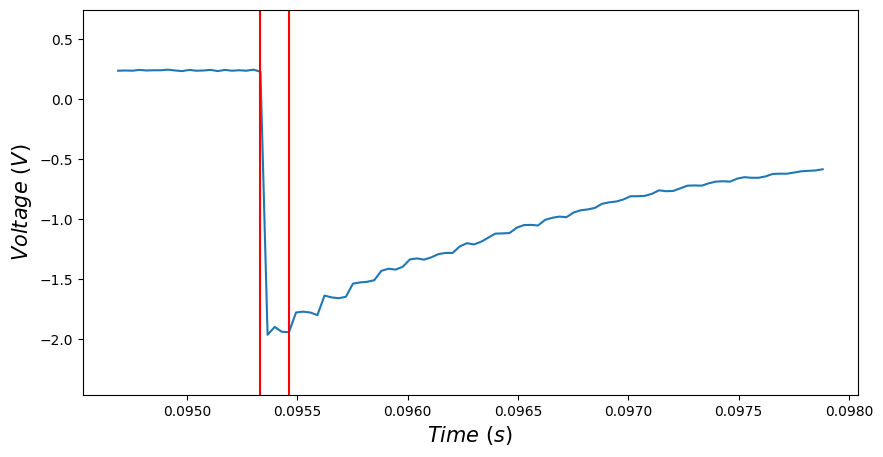

Timed delay is 0.00012904516258079035 ms


In [68]:
t_falling_delay = ut.time_delay(v_falling_seg, t_falling_seg, display=True)
print('Timed delay is {} ms'.format(t_falling_delay))

In [69]:
p_falling_fault = ut.fault_point(t_falling_delay)

print('Distance to the fault is {} m'.format(p_falling_fault))

Distance to the fault is 18.59218179882737 m


In [70]:
#model performance
performance = ut.performance_metrics(17.44, p_falling_fault, metrics=['mse'])
print('Model performance metrics outcome for a single falling edge:', performance)

Model performance metrics outcome for a single falling edge: Metrics(mse=1.3275228975490683, rmse=1.1521817988273675)


### Average time delay from the signal

In the following sections, we'll obtain time delay from all rising and falling edges and compute their average

In [71]:
#locate rising rising edges and a falling edges in the signal
short_17m_edges_indices = ut.edges_detection(v_short_17m, t, num_edges, win_size, prior_samples, overlap_threshold)

print(short_17m_edges_indices)

{'rising_edges': [961, 4758, 8524], 'falling_edges': [2955, 6756]}


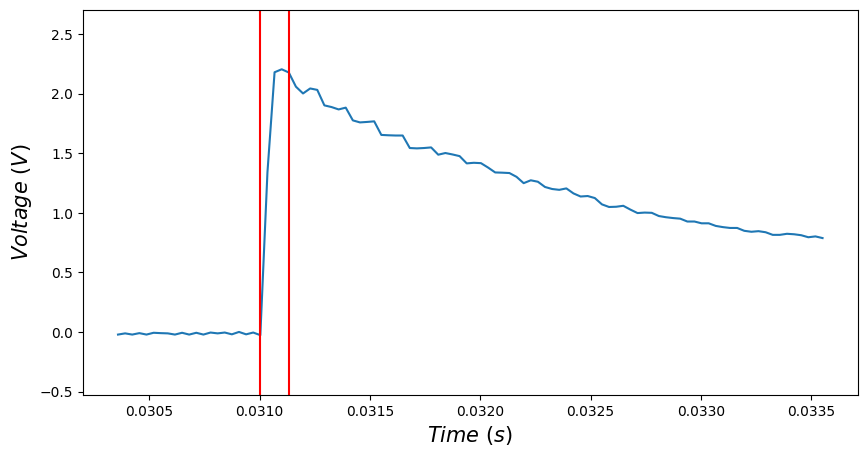

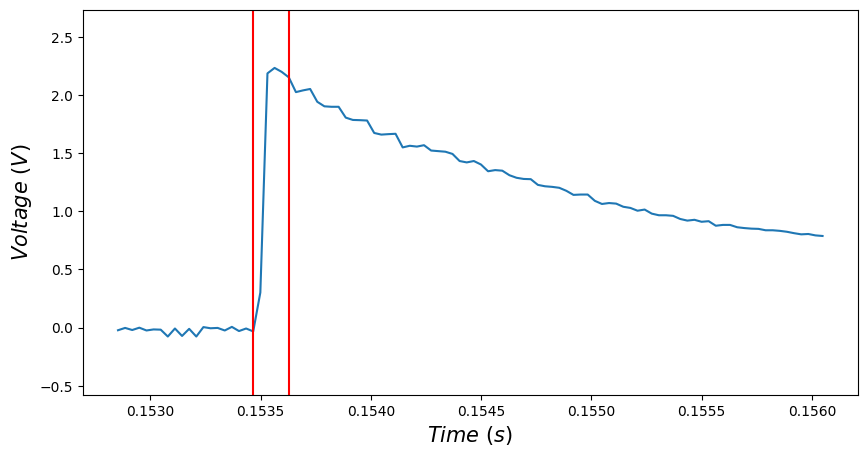

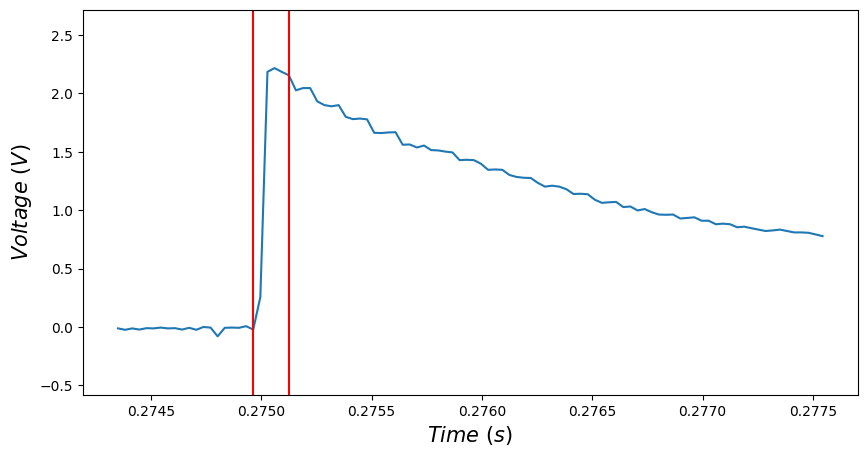

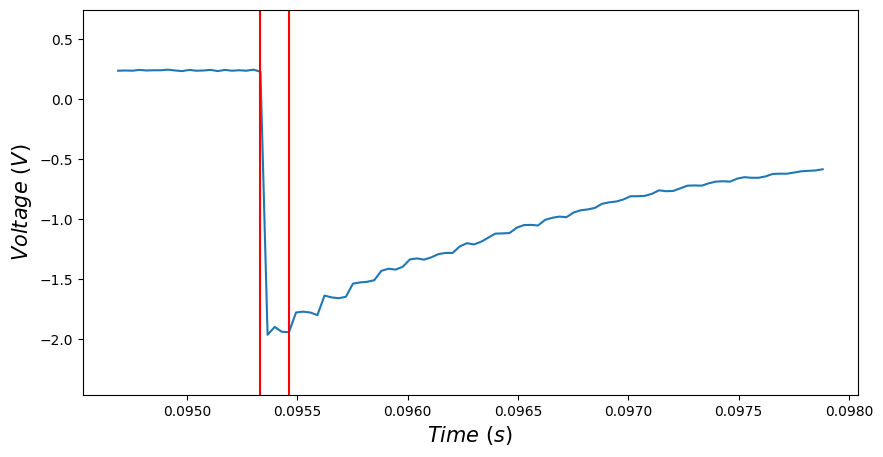

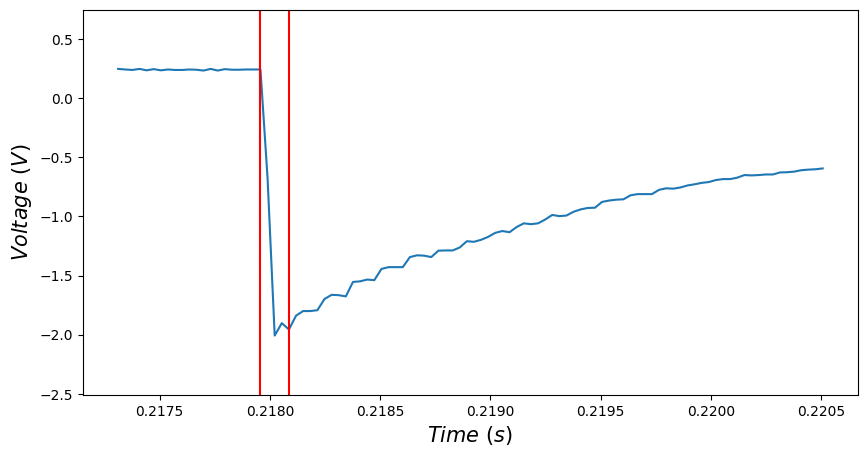

[0.00012905 0.00012905 0.00012905 0.00012905 0.00012905]
Average time delay is 0.00012904516258077994 ms


In [72]:
avg_t_short_17m_delay,  t_short_17m_delays = ut.avg_delay(short_17m_edges_indices, win_size, v_short_17m, t, prior_samples)

print(t_short_17m_delays)
print('Average time delay is {} ms'.format(avg_t_short_17m_delay))

In [73]:
#let's compute distance to the fault using the average time delay
p_short_fault = ut.fault_point(avg_t_short_17m_delay)

print('Distance to the fault is {} m'.format(p_short_fault))

Distance to the fault is 18.59218179882587 m


In [74]:
#model performance
performance = ut.performance_metrics(17.44, p_short_fault, metrics=['mse'])
print('Model performance metrics outcome for the whole signal:', performance)

Model performance metrics outcome for the whole signal: Metrics(mse=1.3275228975456135, rmse=1.1521817988258682)


Let's load all files under open circuit, obtain time delay from each signal and compute the length of the cable

In [75]:
short_17m_circuit_files = {}
files = []
avg_time_delay_ms = []
distance_to_fault = []
e_values = []
paths = ut.file_paths(short_17m_files_dir) #generate paths to each file

for file_path in paths:
    v_short_17m = ut.file_loader(file_path) #load the file
    valid_file = ut.file_validity(v_short_17m, num_samples, threshold) #check if there was a bus conflict while saving the file
    
    if valid_file:
        short_17m_edges_indices = ut.edges_detection(v_short_17m, t, num_edges, win_size, prior_samples, overlap_threshold)
        avg_t_short_17m_delay,  t_short_17m_delays = ut.avg_delay(short_17m_edges_indices, win_size, v_short_17m, t, prior_samples, display=False)
        p_short_fault = ut.fault_point(avg_t_short_17m_delay)
        
        files.append(file_path)
        avg_time_delay_ms.append(avg_t_short_17m_delay)
        distance_to_fault.append(p_short_fault)
        e_values.append(17.44)
        
short_17m_circuit_files = {'files': files,
                      'avg_time_delay_ms': avg_time_delay_ms,
                      'distance_to_fault': distance_to_fault}

df_short_17m = pd.DataFrame(short_17m_circuit_files)
        
df_short_17m

,files,avg_time_delay_ms,distance_to_fault
0,./data/short-circuit/17m/short-106-17-1.csv,0.000129,18.592182
1,./data/short-circuit/17m/short-106-17-10.csv,0.000129,18.592182
2,./data/short-circuit/17m/short-106-17-11.csv,0.000129,18.592182
3,./data/short-circuit/17m/short-106-17-12.csv,0.000129,18.592182
4,./data/short-circuit/17m/short-106-17-13.csv,0.000129,18.592182
5,./data/short-circuit/17m/short-106-17-14.csv,0.000129,18.592182
6,./data/short-circuit/17m/short-106-17-15.csv,0.000129,18.592182
7,./data/short-circuit/17m/short-106-17-16.csv,0.000129,18.592182
8,./data/short-circuit/17m/short-106-17-17.csv,0.000129,18.592182
9,./data/short-circuit/17m/short-106-17-18.csv,0.000129,18.592182


In [76]:
#model performance
performance = ut.performance_metrics(e_values, distance_to_fault)
print('Model performance metrics outcome for all data:', performance)

Model performance metrics outcome for all data: Metrics(mse=2.866337813594483, rmse=1.693026229446692, mae=1.373517296429969, irm=0.9523809523809523)
